## Crawl tweets by API

In [1]:
# ! pip install tqdm
# ! pip install tweepy
# ! pip install torch
# ! pip install transformers
# ! pip install emoji

In [ ]:
# https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Tweet-Lookup/get_tweets_with_bearer_token.py
import requests
import json
import time
from tqdm import tqdm

# To set your bearer token:
bearer_token = "AAAAAAAAAAAAAAAAAAAAAGdZbgEAAAAAlXMiIg%2F96Ygnv%2FmvFDMsWb6LuSw%3DPTSIRz5g0G9RaB9pxp8QhdTtHxXnhEZsjLkpNyqQBR8EfRy8WS"


def create_url(ids):
    tweet_fields = "tweet.fields=attachments,author_id,context_annotations,conversation_id,created_at,entities,geo,id,in_reply_to_user_id,lang,public_metrics,possibly_sensitive,referenced_tweets,reply_settings,source,text,withheld"
    # Tweet fields are adjustable.
    # Options include:
    # attachments, author_id, context_annotations,
    # conversation_id, created_at, entities, geo, id,
    # in_reply_to_user_id, lang, non_public_metrics, organic_metrics,
    # possibly_sensitive, promoted_metrics, public_metrics, referenced_tweets,
    # source, text, and withheld
    ids = "ids=" + ids
    # print(ids)
    # You can adjust ids to include a single Tweets.
    # Or you can add to up to 100 comma-separated IDs
    url = "https://api.twitter.com/2/tweets?{}&{}".format(ids, tweet_fields)
    return url


def bearer_oauth(r):
    """
    Method required by bearer token authentication.
    """
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2TweetLookupPython"
    return r


def connect_to_endpoint(url):
    response = requests.request("GET", url, auth=bearer_oauth)
    # print(response.status_code)
    if response.status_code != 200:
        raise Exception(
            "Request returned an error: {} {}".format(
                response.status_code, response.text
            )
        )
    return response.json()


def crawl_and_save(f_in, f_out):
    train_id_list = []
    for l in f_in.readlines():
        train_id_list.extend(l.strip().split(","))
    start_id = 0
    end_id = start_id + 100
    train_id_len = len(train_id_list)
    # max 100 tweet
    split_crawl = []
    while start_id < train_id_len:
        split_crawl.append(",".join(train_id_list[start_id:end_id]))
        start_id = end_id
        end_id = start_id + 100

    crawl_count = 0
    for ids in tqdm(split_crawl):
        url = create_url(ids)
        json_response = connect_to_endpoint(url)
        for x in json_response["data"]:
            json.dump(x, open(f_out + str(x["id"]) + ".json", "w"))
        crawl_count += 1
        if crawl_count % 290 == 0:
            time.sleep(790)

# un-comment to crawl tweets
def main():
    print("crawl the train tweets")
    #crawl_and_save(open("data/train.data.txt", "r"), "data/train_tweet/")
    # print("crawl the dev tweets")
    # crawl_and_save(open("data/dev.data.txt", "r"), "data/dev_tweet/")
    # print("crawl the analysis tweets")
    # crawl_and_save(open("data/covid.data.txt", "r"), "data/analysis_tweet/")
    print("Finished!")

if __name__ == "__main__":
    main()


## Dataset read-in

Read-in tweets and labels, then sort one tweet with retweets by time

In [47]:
import os
import json
import time
train_ids = open("data/train.data.txt", "r")
train_labels = open("data/train.label.txt", "r")
dev_ids = open("data/dev.data.txt", "r")
dev_labels = open("data/dev.label.txt", "r")

def read_train_ids_labels(ids, labels, test = False):
    train_set = []
    train_label = []
    for train_ids_str, label in zip(ids.readlines(), labels.readlines()):
        train_ids_list = train_ids_str.strip().split(",")
        temp_json_list = []
        if os.path.exists("data/train_tweet/" + train_ids_list[0] + ".json"):
            for train_id in train_ids_list:
                train_path = "data/train_tweet/" + train_id + ".json"
                if os.path.exists(train_path):
                    temp_json_list.append(json.load(open(train_path, "r")))
        # sort according to time
        temp_json_list = sorted(temp_json_list, key=lambda x: time.mktime(time.strptime(x["created_at"], '%Y-%m-%dT%H:%M:%S.%fZ')))
        train_set.append(temp_json_list)
        if label.strip() == "rumour":
            train_label.append(1)
        else:
            train_label.append(0)

    return train_set, train_label


def read_dev_ids_labels(ids, labels, test = False):
    train_set = []
    train_label = []
    for train_ids_str, label in zip(ids.readlines(), labels.readlines()):
        train_ids_list = train_ids_str.strip().split(",")
        temp_json_list = []
        if os.path.exists("data/dev_tweet/" + train_ids_list[0] + ".json"):
            for train_id in train_ids_list:
                train_path = "data/dev_tweet/" + train_id + ".json"
                if os.path.exists(train_path):
                    temp_json_list.append(json.load(open(train_path, "r")))
        # sort according to time
        temp_json_list = sorted(temp_json_list, key=lambda x: time.mktime(time.strptime(x["created_at"], '%Y-%m-%dT%H:%M:%S.%fZ')))
        train_set.append(temp_json_list)
        if label.strip() == "rumour":
            train_label.append(1)
        else:
            train_label.append(0)

    return train_set, train_label

train_set, train_label = read_train_ids_labels(train_ids, train_labels)
dev_set, dev_label = read_dev_ids_labels(dev_ids, dev_labels)
print("Finished!")

Finished!


In [77]:
train_set[1][0]
# print("dev:", dev_set[0])

{'lang': 'en',
 'conversation_id': '554886875303780352',
 'attachments': {'media_keys': ['3_554884286327685120']},
 'reply_settings': 'everyone',
 'public_metrics': {'retweet_count': 184,
  'reply_count': 35,
  'like_count': 44,
  'quote_count': 0},
 'source': 'TweetDeck',
 'entities': {'urls': [{'start': 62,
    'end': 84,
    'url': 'http://t.co/KC8nCzimBl',
    'expanded_url': 'http://www.telegraph.co.uk/news/worldnews/europe/france/11341295/French-police-chief-committed-suicide-after-Charlie-Hebdo-attack.html',
    'display_url': 'telegraph.co.uk/news/worldnews…'},
   {'start': 85,
    'end': 107,
    'url': 'http://t.co/EnZQarIezF',
    'expanded_url': 'https://twitter.com/Telegraph/status/554886875303780352/photo/1',
    'display_url': 'pic.twitter.com/EnZQarIezF'}],
  'hashtags': [{'start': 41, 'end': 54, 'tag': 'CharlieHebdo'}]},
 'id': '554886875303780352',
 'text': 'French police chief killed himself after #CharlieHebdo attack http://t.co/KC8nCzimBl http://t.co/EnZQarIezF',
 

## 绘制树结构

In [115]:
record=train_set[0]

index2tweetid=dict()
tweetid2index=dict()

nodes=[]
edges=[]

for i,tweet in enumerate(record):
    index2tweetid[i]=tweet['id']
    tweetid2index[tweet['id']]=i

for i,tweet in enumerate(record):
    nodes.append(i)
    if 'referenced_tweets' in tweet.keys():
        source=i
        target=tweetid2index[tweet['referenced_tweets'][0]['id']]
        edges.append((source,target))

KeyError: '1250218948701769728'

In [99]:
import networkx as nx

tree = nx.DiGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)

nx.draw_networkx(tree)

In [95]:
# attention: some data may contain multiple trees处理思路:
# 遍历所有tweet，构建出多个树，只保留o(根节点)所在的树 

def build_tree_from_record(record):
    """
    # 基于一条数据(包含多条tweet)，获取到
    *树中的边信息
    * 下标到原始tweet id的映射
    *原始tweet id到下标的映射
    """
    edges = [] 
    nodes = set()
    index2id = dict() # 下标 ->原始id 
    id2index = dict() # 原始id -> 下标 
    id2raw = dict()
    
    for i, tweet in enumerate(record):# 扫描一条数据下的所有tweet
            #记录下标和idstr之间的对应关系 
        id2index[tweet['id']] = i 
        index2id[i] = tweet['id'] 
        id2raw[tweet['id']] = tweet

    index2treeid = {0:0}  #节点下标 ->树id
    parent2children = dict()  #父节点->孩子节点集合

                 
    def recursive_color(node_index):
        treeid = index2treeid[node_index]
#         print(f"treeid: {treeid}")
        if node_index in parent2children:  #当前节点有孩子
            # for child in parent2children[node_index]: 
                # index2treeidichild1=treeid  #子节点与父节点tree id一致
            for child in parent2children[node_index]:
                if child not in index2treeid or index2treeid[child] != treeid:
                    index2treeid[child] = treeid
                    recursive_color(child)

                    
    child2parent=dict()   #子节点指向父节点 
    for i,tweet in enumerate(record):
        #记录边信息
        if 'referenced_tweets' in tweet.keys():
            #父节点原始id
            parent_id = tweet['referenced_tweets'][0].get('id',-1)
            #父节点下标(可能为空)
            parent_index=id2index.get(parent_id,-1)

            if parent_index != -1: #可以找到父节点
                child2parent[i] = parent_index

                #将当前节点放入父节点的孩子集合中
                if parent_index not in parent2children:
                    parent2children[parent_index]=set() 
                parent2children[parent_index].add(i)

                #如果父节点已经有树，递归将所有底层节点设置为同一棵树 
                if parent_index in index2treeid:
                    recursive_color(parent_index) 
                else: #否则新建一颗树(只有两个节点)
                    tree_id = len(index2treeid) 
                    index2treeid[i] = tree_id
                    index2treeid[parent_index] = tree_id
            else:
            #print(f"节点{id2index[tweet['id_str']]}:无法找到父节点") 
                pass
            
    # 提取出tree_id为0的节点和边信息
    for node_index, tree_id in index2treeid.items():
        if tree_id == 0:
            nodes.add(node_index)
            if node_index in child2parent:
                edges.append([node_index, child2parent[node_index]])
    
    return nodes, edges, index2id, id2index, index2treeid, id2raw, parent2children

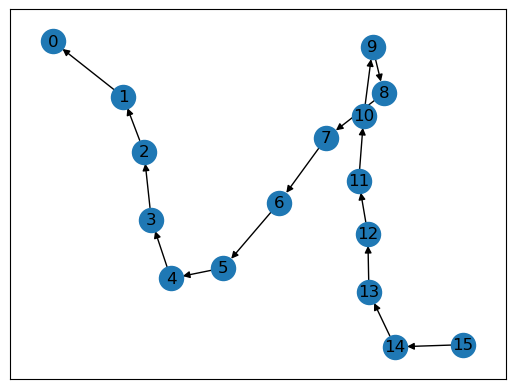

In [114]:
import networkx as nx
import matplotlib.pyplot as plt

result = build_tree_from_record(train_set[0])
result[-1]
nodes=result[0]
edges=result[1]

tree = nx.DiGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)

nx.draw_networkx(tree)
plt.show(tree)

# 暂时不管

In [8]:
# read in test data
test_ids = open("data/test.data.txt", "r")
test_set = []
for test_ids_str in test_ids.readlines():
    test_ids_list = test_ids_str.strip().split(",")
    temp_json_list = []
    for test_id in test_ids_list:
        test_path = "data/tweet-objects/" + test_id + ".json"
        if os.path.exists(test_path):
            temp_json_list.append(json.load(open(test_path, "r")))

    # sort according to time
    temp_json_list = sorted(temp_json_list, key=lambda x: time.mktime(time.strptime(x["created_at"], '%a %b %d %H:%M:%S +0000 %Y')))
    # temp_json_list = sorted(temp_json_list, key=lambda x: time.mktime(time.strptime(x["created_at"], '%Y-%m-%dT%H:%M:%S.%fZ')))
    test_set.append(temp_json_list)

print("Finished!")

Finished!


In [9]:
# print(test_set[0])

Try to use workshop 10 bert model

In [10]:
from transformers import AutoModel, AutoTokenizer
from transformers import AdamW
import torch
pre_trained_weights = "vinai/bertweet-covid19-base-uncased"
bertweet = AutoModel.from_pretrained(pre_trained_weights)
tokenizer = AutoTokenizer.from_pretrained(pre_trained_weights, normalization=True)

Some weights of the model checkpoint at vinai/bertweet-covid19-base-uncased were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Combine a tweet and its retweets into one string

In [11]:
def combine_tweet_retweet(train_set):
    all_tweets = []

    for tweets in train_set:
        tweets_list = []
        for tweet in tweets:
            text = tweet["text"]
            text_list = []
            # replace @user and http
            for word in text.split(" "):
                if len(word) > 1 and word[0] == "@":
                    text_list.append("@USER")
                elif len(word) > 4 and word[0:4] == "http":
                    text_list.append("HTTPURL")
                else:
                    text_list.append(word)
            new_text = " ".join(text_list)
            tweets_list.append(new_text)
        all_tweets.append(tokenizer.sep_token.join(tweets_list))

    return all_tweets

train_text = combine_tweet_retweet(train_set)
dev_text = combine_tweet_retweet(dev_set)
test_text = combine_tweet_retweet(test_set)

In [21]:
train_text[0]

'4. Can eating garlic help prevent infection with the new coronavirus? #COVID19Malaysia HTTPURL</s>5. Can regularly rinsing your nose with saline help prevent infection with the new coronavirus? HTTPURL</s>6. Do vaccines against pneumonia protect you against the new coronavirus? HTTPURL</s>7. Can spraying alcohol or chlorine all over your body kill the new coronavirus? #Chamber HTTPURL</s>8. How effective are thermal scanners in detecting people infected with the new coronavirus? HTTPURL</s>9. Can an ultraviolet disinfection lamp kill the new coronavirus? HTTPURL</s>10. Are hand dryers effective in killing the new coronavirus? HTTPURL</s>11. The new coronavirus CANNOT be transmitted through mosquito bites. HTTPURL</s>12. Taking a hot bath does not prevent the new coronavirus disease HTTPURL</s>13. Cold weather and snow CANNOT kill the new coronavirus. HTTPURL</s>14. COVID-19 virus can be transmitted in areas with hot and humid climates HTTPURL</s>15. Drinking alcohol does not protect y